# Trabalho da disciplina de algoritmos não-supervisionados - Unsupervised Algorithms Coursework



In [228]:
import numpy as np
import scipy
import scipy.spatial
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white", palette="pastel")
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 
from sklearn.metrics import silhouette_samples

## Data-preparation

In [229]:
#Reading the dataset "Country-data" from kaggle

country_data = pd.read_csv("../../datasets/Country-data.csv")
country_data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [230]:
#From the Kaggle we know exports, health and imports are represented as percentage of gdpp column. To convert it:

country_data['exports'] = country_data['exports']*country_data['gdpp']/100
country_data['imports'] = country_data['imports']*country_data['gdpp']/100
country_data['health'] = country_data['health']*country_data['gdpp']/100

In [231]:
# Checking outliers at 25%,50%,75%,90%,95% and 99%
country_data.describe(percentiles=[.25,.5,.75,.90,.95,.99])

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,7420.618847,1056.733204,6588.352108,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,17973.885795,1801.408906,14710.810418,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,1.076920,12.821200,0.651092,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,447.140000,78.535500,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.886000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,7278.000000,976.940000,7719.600000,22800.000000,10.750000,76.800000,3.880000,14050.000000
90%,100.220000,17760.600000,3825.416000,15034.280000,41220.000000,16.640000,80.400000,5.322000,41840.000000
95%,116.000000,31385.100000,4966.701000,24241.560000,48290.000000,20.870000,81.400000,5.861000,48610.000000
99%,153.400000,64794.260000,8410.330400,55371.390000,84374.000000,41.478000,82.370000,6.563600,79088.000000


/home/higoreller/miniconda3/envs/clustering-env/lib/python3.9/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


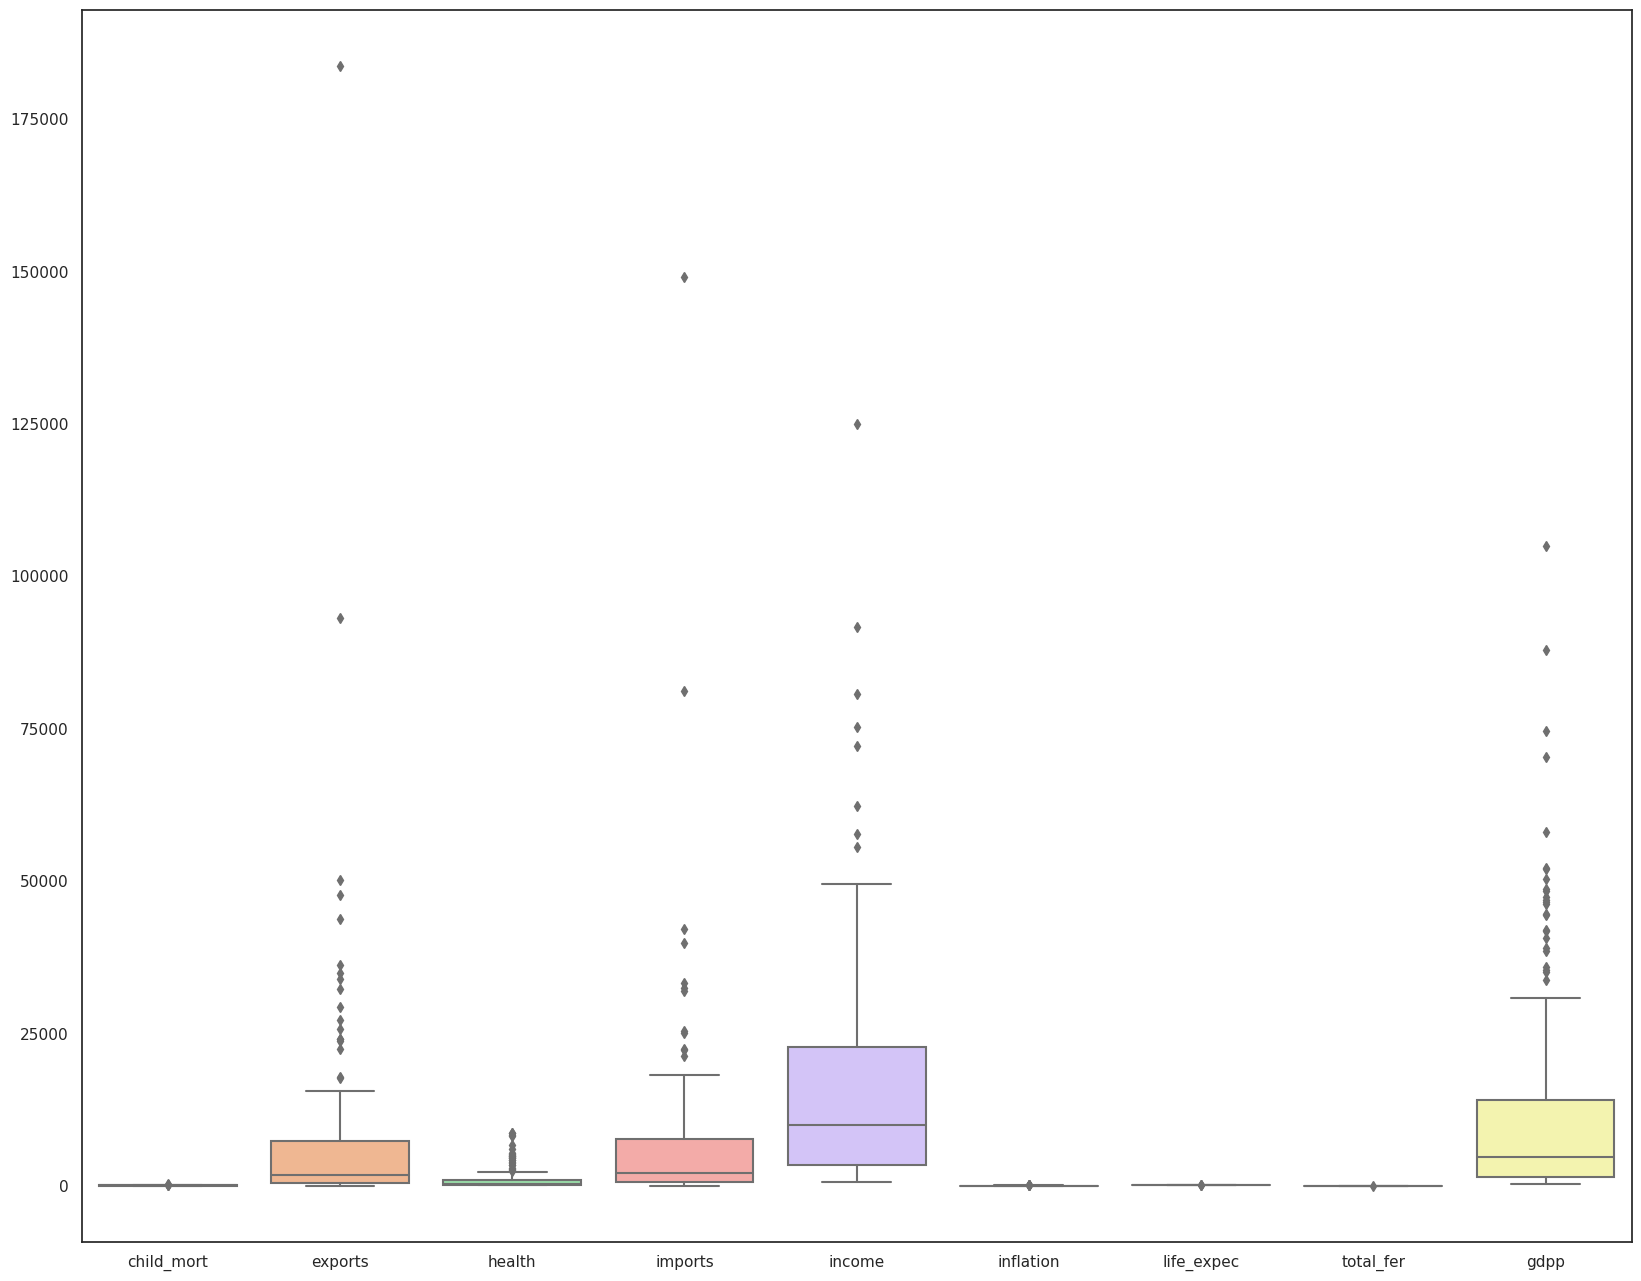

In [232]:
#Showing the box plot
fig = plt.figure(figsize = (20,16))
sns.boxplot(data=country_data)
plt.show()

In [233]:
print("The number of countries are : ", country_data.shape[0])

The number of countries are :  167


In [234]:
country_data.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [235]:
country_data.isna().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

## Silhouette Method

In [236]:
# First let us see if we can explain the dataset using fewer variables

# Droping string feature country name.
country_data_droped = country_data.drop('country', 1) 
scaler = MinMaxScaler()
country_scaled = scaler.fit_transform(country_data_droped)

/tmp/ipykernel_4781/1263554974.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  country_data_droped = country_data.drop('country', 1)


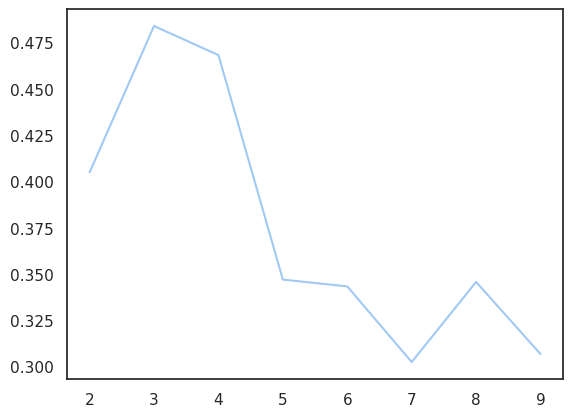

In [237]:
from sklearn.metrics import silhouette_score
sse_ = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k).fit(country_scaled)
    sse_.append([k, silhouette_score(country_scaled, kmeans.labels_)])
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1])
plt.show()

In [238]:
def plot_clustering(data, labels, title=None):
    x_min, x_max = np.min(data, axis=0), np.max(data, axis=0)
    data = (data - x_min) / (x_max - x_min)
    fig = plt.figure(1, figsize=(4, 3))
    plt.figure(figsize=(6, 4))
    plt.scatter(data[:, 0], data[:, 1],
                 c=labels.astype(np.float))
    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

/tmp/ipykernel_4781/3870967813.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=labels.astype(np.float))


<Figure size 400x300 with 0 Axes>

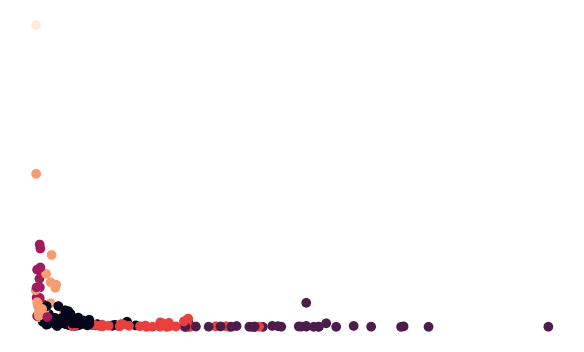

In [239]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(country_scaled)
labels = kmeans.labels_
plot_clustering(country_scaled, labels)
plt.show()

Para n_clusters = 2 O score_silhouette médio é : 0.4321728445818114
Para n_clusters = 3 O score_silhouette médio é : 0.48597181377655346
Para n_clusters = 4 O score_silhouette médio é : 0.4780612703542198
Para n_clusters = 5 O score_silhouette médio é : 0.34356017472757616
Para n_clusters = 6 O score_silhouette médio é : 0.3376363516024061


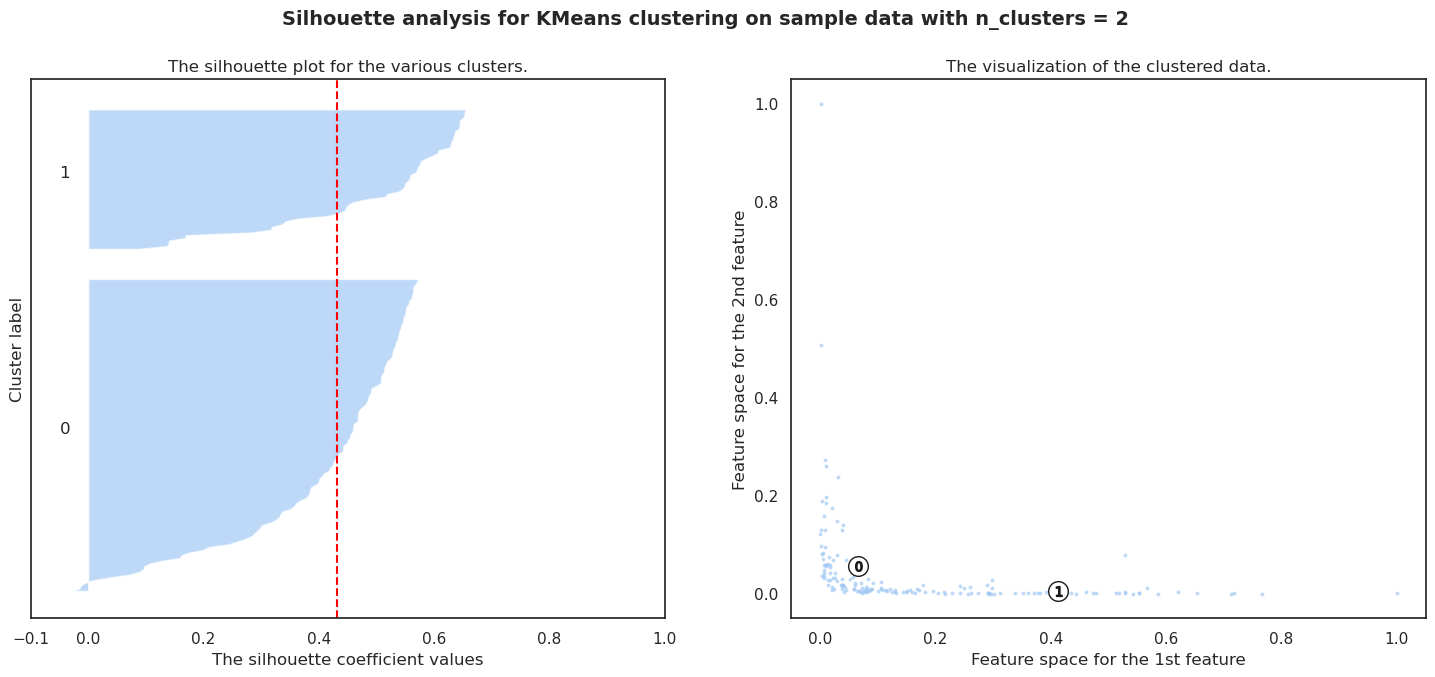

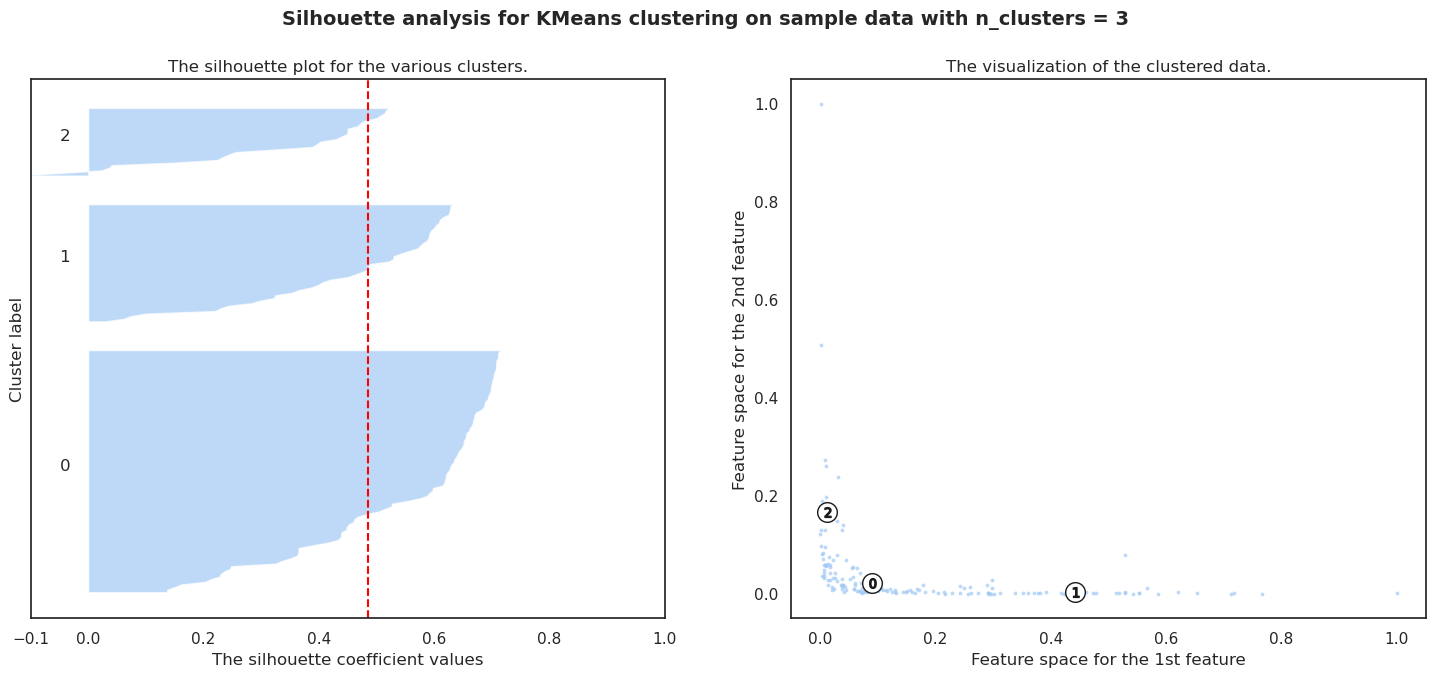

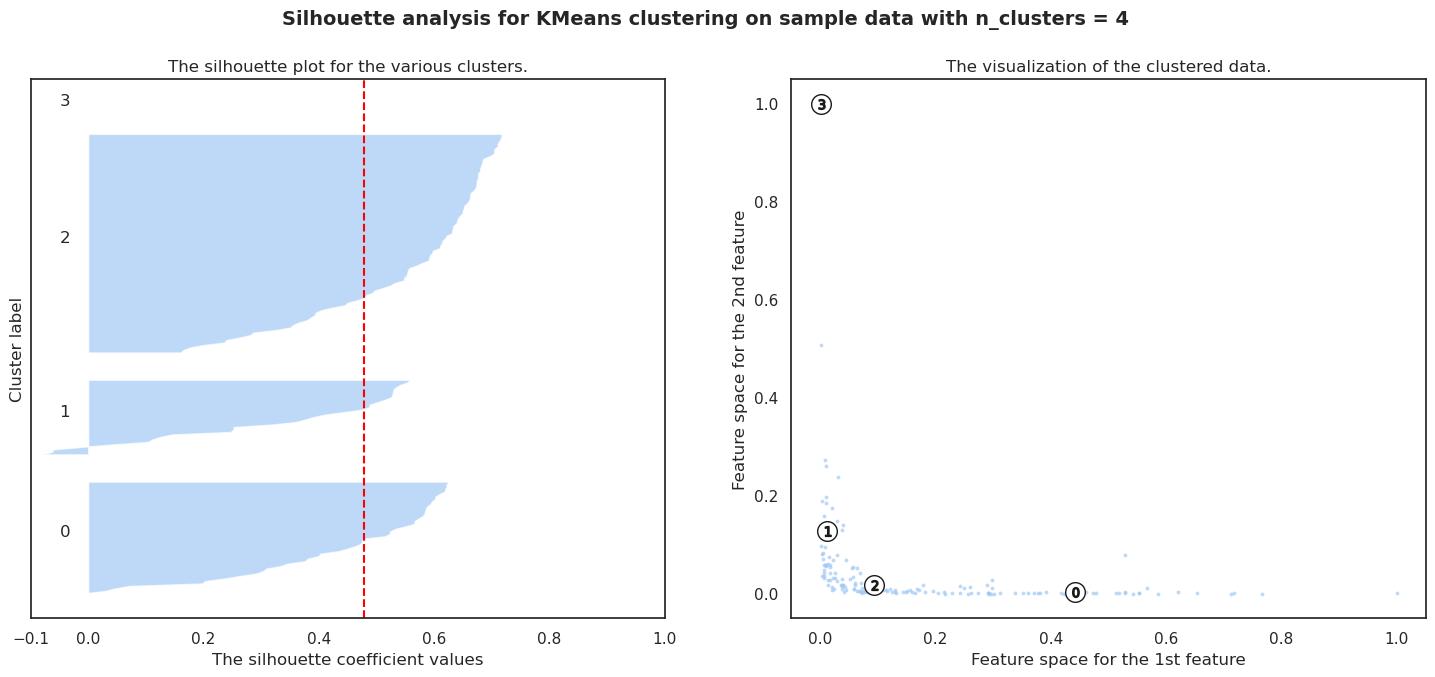

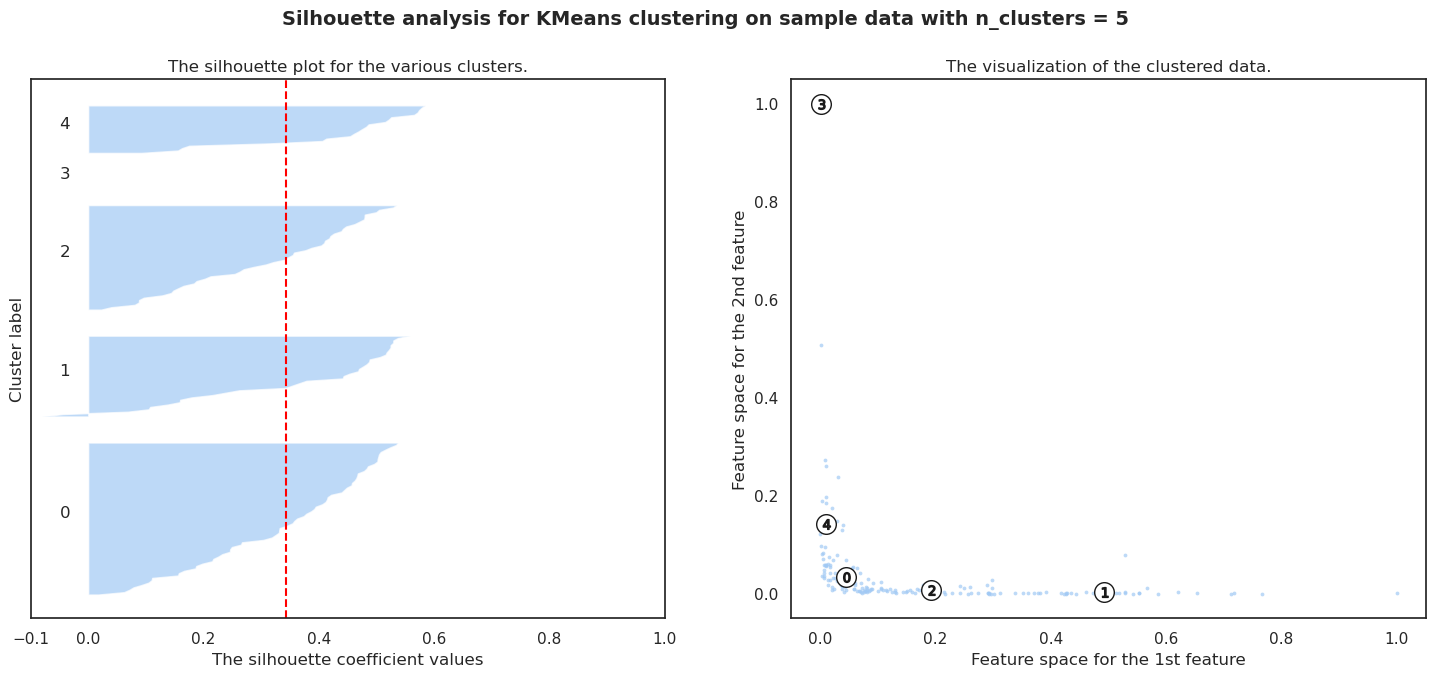

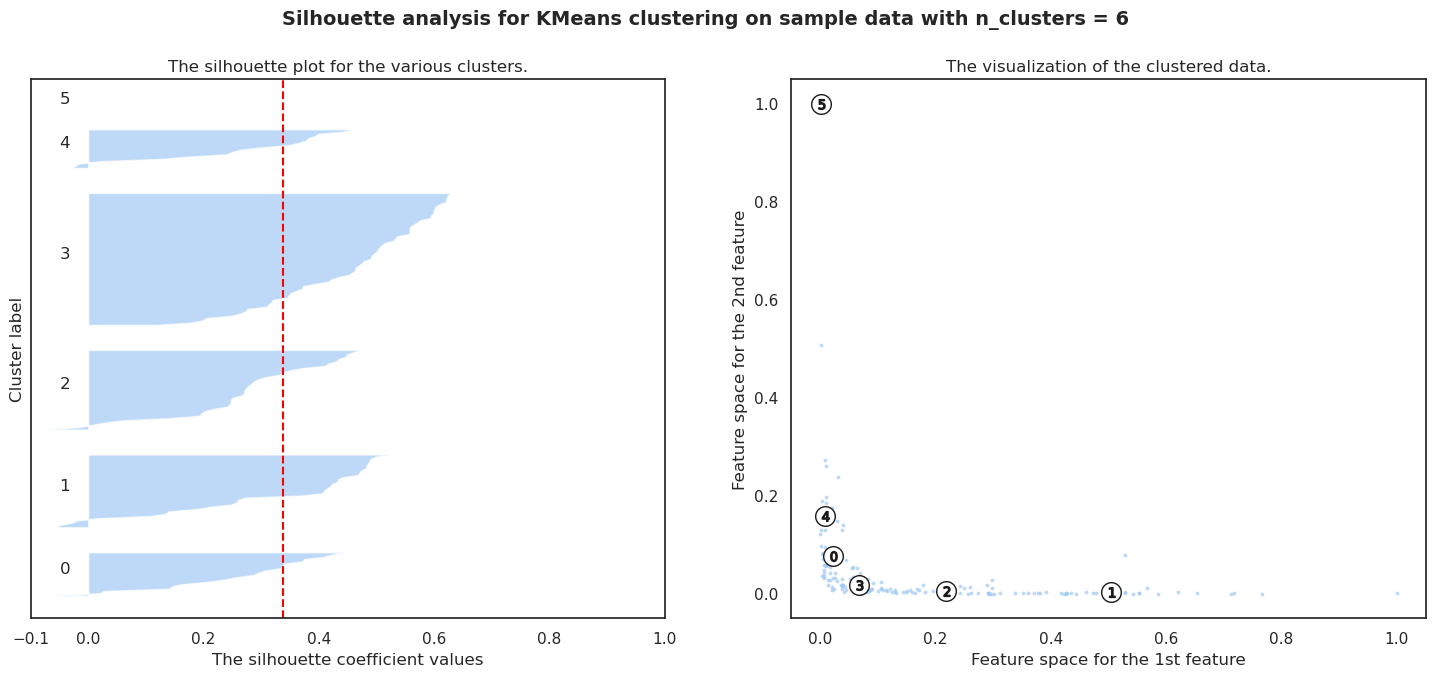

In [240]:
range_n_clusters = [2, 3, 4, 5, 6]
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(country_scaled) + (n_clusters + 1) * 10])
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(country_scaled)
# The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(country_scaled, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "O score_silhouette médio é :", silhouette_avg)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(country_scaled, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = plt.nipy_spectral()
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color,       alpha=0.7)
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    # 2nd Plot showing the actual clusters formed
    colors = plt.nipy_spectral()
    ax2.scatter(country_scaled[:, 0], country_scaled[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
plt.show()

## Elbow Method

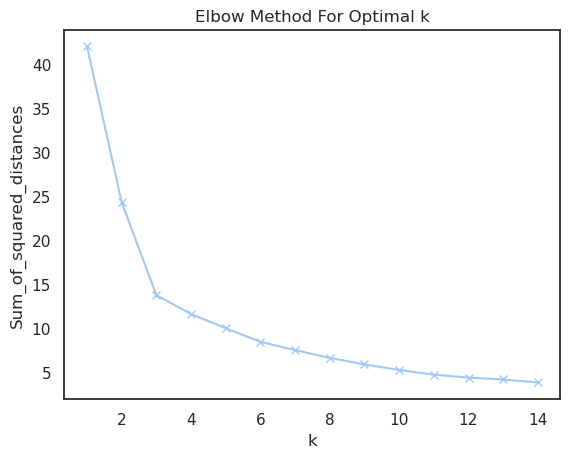

In [241]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(country_scaled)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

## CLUSTERING

In [242]:
kmeans = KMeans(n_clusters=3)
k_fit = kmeans.fit(country_scaled)

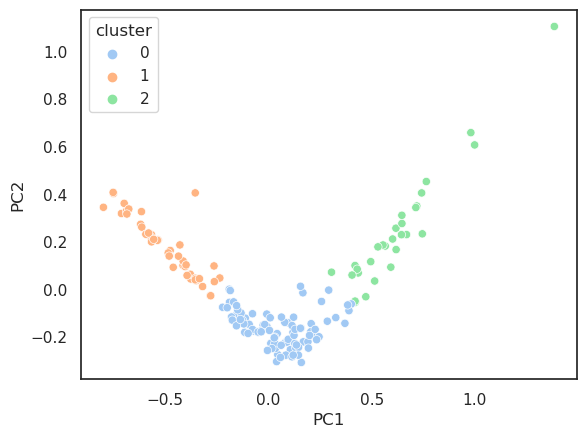

In [243]:
def plot_cluster_points(df, kmeans):
    pca = PCA(2) 
    pca_data = pd.DataFrame(pca.fit_transform(df), columns=['PC1','PC2']) 
    pca_data['cluster'] = pd.Categorical(kmeans.labels_)
    sns.scatterplot(x="PC1", y="PC2", hue="cluster", data=pca_data)

plot_cluster_points(country_scaled, kmeans)

## Hierarchical clustering

Text(0, 0.5, 'Euclidean Distance')

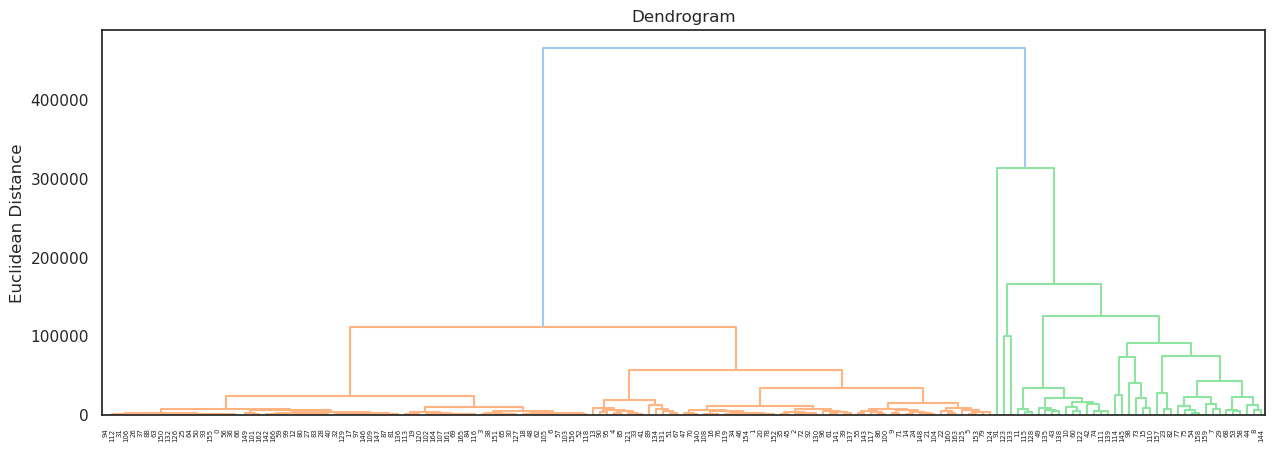

In [244]:
import scipy.cluster.hierarchy as sch

plt.figure(figsize=(15, 5))
plt.grid(False)
dendrogram = sch.dendrogram(sch.linkage(country_data_droped, method='ward'), labels=country_data_droped.index)
plt.title('Dendrogram')
plt.ylabel('Euclidean Distance')